In this notebook, we'll train the SpatialDIVA model on the Valdeolivas et al. colorectal cancer dataset, comprising of 12 slides of colorectal cancer tissue from different patients.

For demonstration, we'll restrict the data to two slides for training of the model. After training, we'll extract embeddings from the different latent subspaces of SpatialDIVA, and analyze their covariance. We'll also examine how SpatialDIVA performs in terms of batch correction.

We'll use the high-level SpatialDIVA API to train the model and extract embeddings.

Let's start by loading the necessary modules and the data.

In [2]:
import sys 
import os 
sys.path.append("..")

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc 
import anndata as ann 

from api import StDIVA

We can start by loading the anndata objects for Valdeolivas et al - in this case we'll restrict it to the first two files, corresponding to two slides.

This data has been preprocessed such that spot-level deconvolution has been done, and pathologist annotations are also present in the data. UNI-feature extraction for the spot-level histpathology patches corresponding to the ST spots, has also been done. The appropriate features are stored in the `.obs` attribute of the anndata object, with the identifiers "UNI" before the feature name.

If you haven't download the Valdeolivas et al. processed data, please do so and store it in the appropriate location in `data/valdeolivas_processed`

In [3]:
# Load the first two slides of the Valdeolivas et al dataset
adata_path = "/scratch/hdd001/home/hmaan/visium_datasets/valdeolivas_hest_data"
adata_files = [f for f in os.listdir(adata_path) if f.endswith("processed.h5ad")]
adata_files = [os.path.join(adata_path, f) for f in adata_files]

adata_files_sub = adata_files[:2]
adatas = []
for adata_file in adata_files_sub:
    adata = sc.read_h5ad(adata_file)
    adatas.append(adata)

In [4]:
adatas[0].obs.columns

Index(['array_row_x', 'array_col_x', 'pxl_col_in_fullres',
       'pxl_row_in_fullres', 'in_tissue_x', 'pxl_row_in_fullres_old',
       'pxl_col_in_fullres_old', 'n_genes_by_counts_x',
       'log1p_n_genes_by_counts_x', 'total_counts_x',
       ...
       'UNI-1015', 'UNI-1016', 'UNI-1017', 'UNI-1018', 'UNI-1019', 'UNI-1020',
       'UNI-1021', 'UNI-1022', 'UNI-1023', 'UNI-1024'],
      dtype='object', length=1348)

As we can see, the UNI columns are at the end of the anndata obs attributes, followed by the other metadata. The format of this anndata object is such that each spot corresponds to one observation.

The pathologist annotations per spot are stored in `.obs["Pathologist Annotation]`

The maximally represented cell-type (after deconvolution) per spot is stored in `.obs["ST_celltype"]`

The batch/sample label is stored in `.obs["sample"]`

The positions of each spot on the slide are stored in `.obsm["spatial"]`

We'll need the following information for SpatialDIVA training - 

- The dimensionality of the UNI features
- The dimensionality of the pathologist annotations (total number of classes)
- The dimensionality of the batch/sample labels (total number of classes)
- The dimensionality of the ST celltypes (total number of classes)
- The dimensionality of the neighborhood context for each spot (50 dimensional by default)

Let's go ahead and extract those from the loaded data

In [10]:
from sklearn.preprocessing import LabelEncoder

counts_dim = 2500 # Because we are using 2500 HVGS in the processor later - the default
uni_cols = [col for col in adatas[0].obs.columns if "UNI" in col]
hist_dim = len(uni_cols)
# When getting unique values, combine the celltypes from both slides
y1_dim = len(np.unique(np.concatenate([adatas[0].obs["ST_celltype"].values, adatas[1].obs["ST_celltype"].values])))
y2_dim = 100 # 50 PCs for the ST data and 50 PCs for the UNI data - neighbourhood context 

# Transform path labels due to string encoding and character issues
# When getting unique values, combine the pathologist annotations from both slides
path_labels = np.concatenate([adatas[0].obs["Pathologist Annotation"].values, adatas[1].obs["Pathologist Annotation"].values]) 
le = LabelEncoder()
path_labels = le.fit_transform(path_labels)

y3_dim = len(np.unique(path_labels))
d_dim = 2 # For two slides

We can explore the data further here, or load it into the StDIVA API. This API will also take in the file locations, and perform relevant preprocessing steps (using the function `adata_process` - more information in the documentation). The API will also perform the training of the model, and extraction of embeddings.

Let's go ahead and initialize the SpatialDIVA API with the necessary parameters.

In [55]:
stdiva = StDIVA(
    counts_dim = counts_dim,
    hist_dim = hist_dim,
    y1_dim = y1_dim,
    y2_dim = y2_dim,
    y3_dim = y3_dim,
    d_dim = d_dim,
    betas = [100, 1, 1, 1, 1, 1] # Greater weight on reconstruction loss for visualization purposes
)

Now we can add the data to the API in the form of a list of files corresponding to the anndata object with the information we've outlined above. 

We'll use 90% of the combined slides for training, and 10% for validation (the default split).

In [56]:
stdiva.add_data(
    adata = adata_files[0:2],
    label_key_y1 = "ST_celltype",
    label_key_y3 = "Pathologist Annotation",
    hist_col_key = "UNI"
)

Processing data..


/h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-PyiMLd3V-py3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-PyiMLd3V-py3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-PyiMLd3V-py3.9/lib/python3.9/site-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-PyiMLd3V-py3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils

Creating dataloaders..


From here, we can go ahead and train the model. The default number of epochs is 100, with early stopping enabled by default. Let's use these parameters for training - we'll train for only 20 epochs for demonstration purposes - training for more epochs will lead to better performance.

In [57]:
stdiva.train(max_epochs=20)

/h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-PyiMLd3V-py3.9/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-Pyi ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | SpatialDIVA | 3.3 M  | train
----------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.168    Total estimated model params size (MB)
110       Modules in train mode
0         Modules in eval mode


Starting training..


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-PyiMLd3V-py3.9/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-PyiMLd3V-py3.9/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-PyiMLd3V-py3.9/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see 

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Training complete!


Now that training is complete we can extract embeddings from the different latent subspaces of the model. We can extract embeddings for the intrinsic transcriptomic variation (Zy1), the spatial context (Zy2), morphology (Zy3), batch effects (Zd), and the residual variation (zx).

These embeddings are based on the combined training and validation data, meaning they are the empirical posterior means of the data `(q(z_i|x))` for each spot. We can extract these embeddings using the `get_embeddings` function.

In [58]:
zd_samples, zy1_samples, zy2_samples, zy3_samples, zx_samples = stdiva.get_embeddings(type = "full") 

We can reduce the embeddings to two dimensional PCA projects using the `reduce` function in the API

In [59]:
zd_reduced = stdiva.reduce_embedding(zd_samples, method = "pca")
zy1_reduced = stdiva.reduce_embedding(zy1_samples, method = "pca")
zy2_reduced = stdiva.reduce_embedding(zy2_samples, method = "pca")
zy3_reduced = stdiva.reduce_embedding(zy3_samples, method = "pca")
zx_reduced = stdiva.reduce_embedding(zx_samples, method = "pca")

Now we can use a built-in function to extract the labels for plotting the embeddings. We can plot the embeddings for the different latent subspaces, and color them by the different labels.

In this case the label for spatial variation (y2) will be the spatial coordinates of the spots.

In [60]:
y1_labels, y2_labels, y3_labels, d_labels = stdiva.get_labels(type = "full")

We'll create a dataframe of the embeddings and then analyze their covariance 

In [61]:
embedding_df = pd.DataFrame({
    "zd_1": zd_reduced[:, 0],
    "zd_2": zd_reduced[:, 1],
    "zy1_1": zy1_reduced[:, 0],
    "zy1_2": zy1_reduced[:, 1],
    "zy2_1": zy2_reduced[:, 0],
    "zy2_2": zy2_reduced[:, 1],
    "zy3_1": zy3_reduced[:, 0],
    "zy3_2": zy3_reduced[:, 1],
    "zx_1": zx_reduced[:, 0],
    "zx_2": zx_reduced[:, 1],
    "y1": y1_labels,
    "y2_1": y2_labels[:, 0],
    "y2_2": y2_labels[:, 1],
    "y3": y3_labels,
    "d": d_labels
})

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
!pip install colorcet 
import colorcet as cc 


2827.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached colorcet-3.1.0-py3-none-any.whl.metadata (6.3 kB)
Using cached colorcet-3.1.0-py3-none-any.whl (260 kB)

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


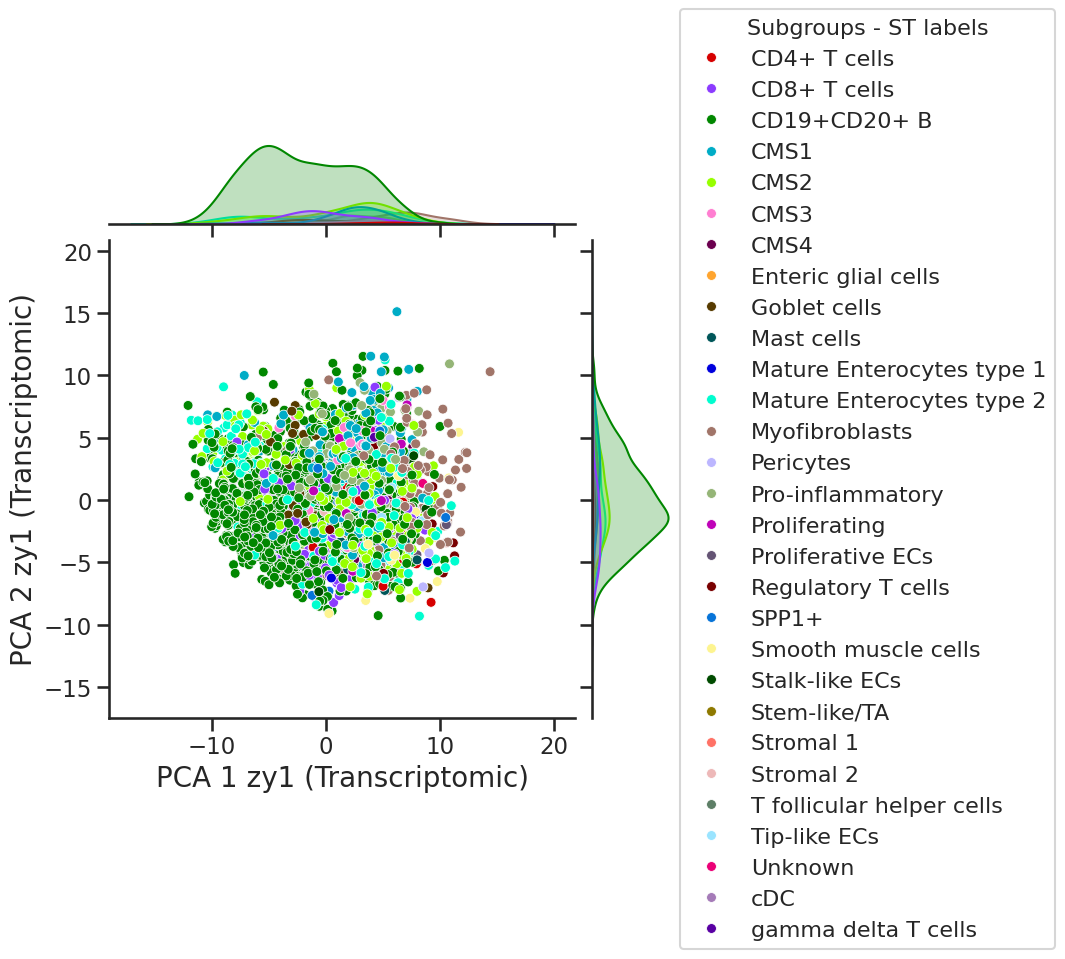

In [62]:
palette = sns.color_palette(cc.glasbey, n_colors=y1_dim)

sns.set_context("talk")
sns.set_style("ticks")

g = sns.jointplot(
    data=embedding_df, 
    x="zy1_1", 
    y="zy1_2", 
    hue="y1", 
    kind="scatter", 
    height=7, 
    palette=palette,
    s=50
)

g.ax_joint.set_xlabel("PCA 1 zy1 (Transcriptomic)", fontsize=20)
g.ax_joint.set_ylabel("PCA 2 zy1 (Transcriptomic)", fontsize=20)

legend = g.ax_joint.legend(
    title='Subgroups - ST labels',
    loc='center left',       
    bbox_to_anchor=(1.2, 0.5), 
    ncol=1,                  
    frameon=True,
    fontsize=16,
    title_fontsize=16,
)

/h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-PyiMLd3V-py3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:1832: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-PyiMLd3V-py3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/h/hmaan/.cache/pypoetry/virtualenvs/spatialdiva-PyiMLd3V-py3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:1889: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


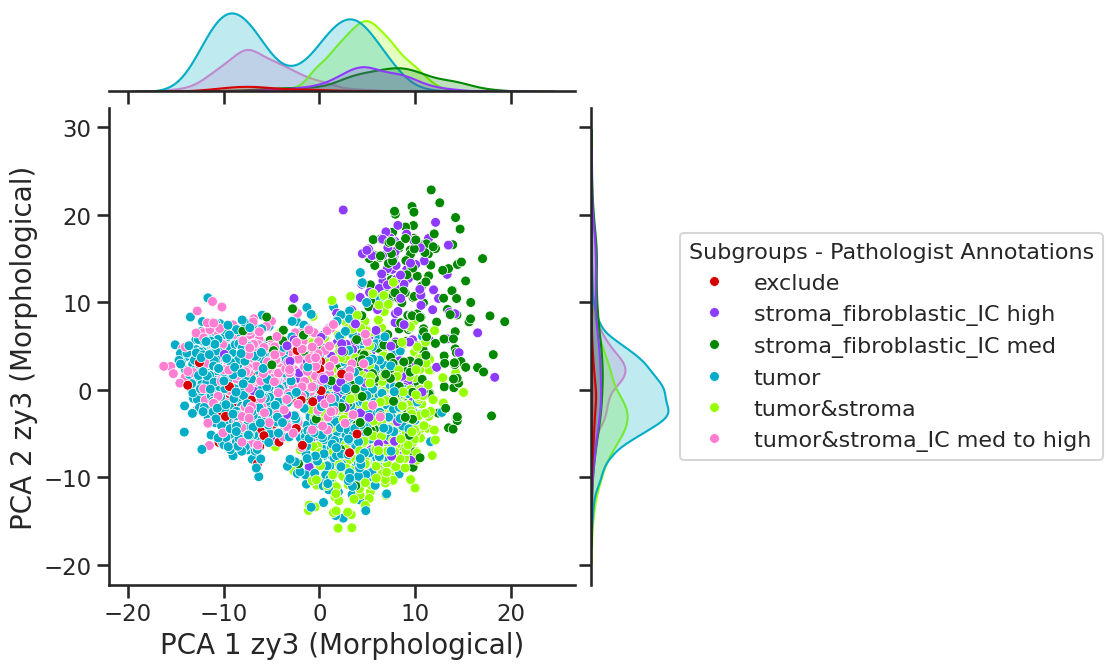

In [64]:
palette = sns.color_palette(cc.glasbey, n_colors=y3_dim)

sns.set_context("talk")
sns.set_style("ticks")

g = sns.jointplot(
    data=embedding_df, 
    x="zy3_1", 
    y="zy3_2", 
    hue="y3", 
    kind="scatter", 
    height=7, 
    palette=palette,
    s=50
)

g.ax_joint.set_xlabel("PCA 1 zy3 (Morphological)", fontsize=20)
g.ax_joint.set_ylabel("PCA 2 zy3 (Morphological)", fontsize=20)

legend = g.ax_joint.legend(
    title='Subgroups - Pathologist Annotations',
    loc='center left',       
    bbox_to_anchor=(1.2, 0.5), 
    ncol=1,                  
    frameon=True,
    fontsize=16,
    title_fontsize=16,
)

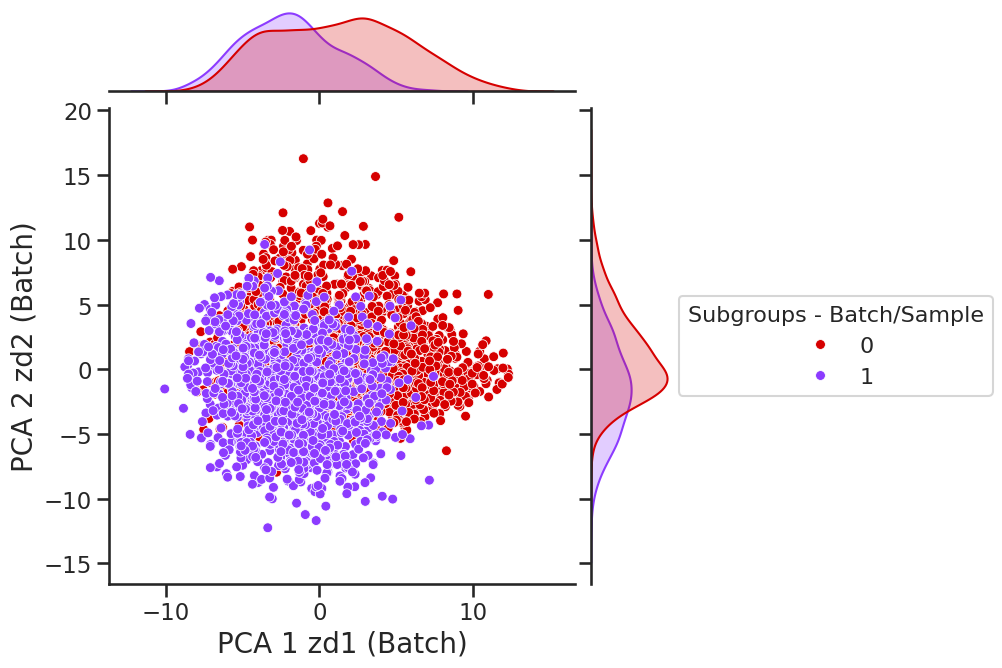

In [66]:
palette = sns.color_palette(cc.glasbey, n_colors=d_dim)

sns.set_context("talk")
sns.set_style("ticks")

g = sns.jointplot(
    data=embedding_df, 
    x="zd_1", 
    y="zd_2", 
    hue="d", 
    kind="scatter", 
    height=7, 
    palette=palette,
    s=50
)

g.ax_joint.set_xlabel("PCA 1 zd1 (Batch)", fontsize=20)
g.ax_joint.set_ylabel("PCA 2 zd2 (Batch)", fontsize=20)

legend = g.ax_joint.legend(
    title='Subgroups - Batch/Sample',
    loc='center left',       
    bbox_to_anchor=(1.2, 0.5), 
    ncol=1,                  
    frameon=True,
    fontsize=16,
    title_fontsize=16,
)

From the plots, we can see that the information for Zy1 is not readily captured by a two dimensional PCA, as there are a very large number of cell-types. 

Within the morphological space, the first two PCs capture separation between combined tumor and stroma populations, and stroma only populations.

Lastly, within the batch space, we can see that the two slides are separated, which is what we would expect based on technical variation captured by Zd. 

We can further visualize how the spatial covariate captures the spatial variation in the data. 

Let's examine PIGR, which is a spatially varying transmemberane protein in the gastroinstestinal tract. We can visualize the expression of PIGR based on the spatial embeddings.

<Figure size 1800x800 with 0 Axes>

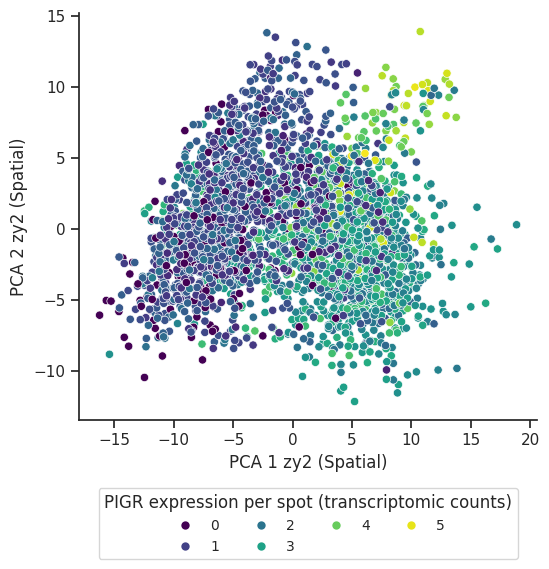

In [71]:
pigr_index = np.where(stdiva.adata.var_names == "PIGR")[0][0]
pigr_expression = stdiva.adata.X[:, pigr_index]
embedding_df["pigr"] = pigr_expression

sns.set(style="ticks")
plt.figure(figsize=(18, 8))
g = sns.relplot(data=embedding_df, x="zy2_1", y="zy2_2", height = 6, hue="pigr", palette="viridis")
# Drop legend
g._legend.remove()
plt.legend(title='PIGR expression per spot (transcriptomic counts)', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize='small', title_fontsize='medium', frameon=True)
plt.xlabel("PCA 1 zy2 (Spatial)")
plt.ylabel("PCA 2 zy2 (Spatial)")
plt.tight_layout(rect=[0, 0, 0.85, 1])